
# PBMC 10k Single‑Cell RNA‑seq Analysis
**Author:** Sahil Bilal  
**Affiliation:** B.Sc. Medical, Cluster University Srinagar  
**Email:** sahiilbilal19@gmail.com  

**Project goal:** End‑to‑end single‑cell RNA‑seq analysis of the 10x Genomics PBMC 10k dataset: QC, normalization, dimensionality reduction (PCA/UMAP), clustering, marker detection. 



In [1]:

!pip install scanpy[leiden] anndata matplotlib seaborn scikit-learn


Initial shape: (11769, 33538)
After QC: (7081, 33538)
Number of HVGs: 3000
 Marker genes saved: pbmc10k_markers.csv


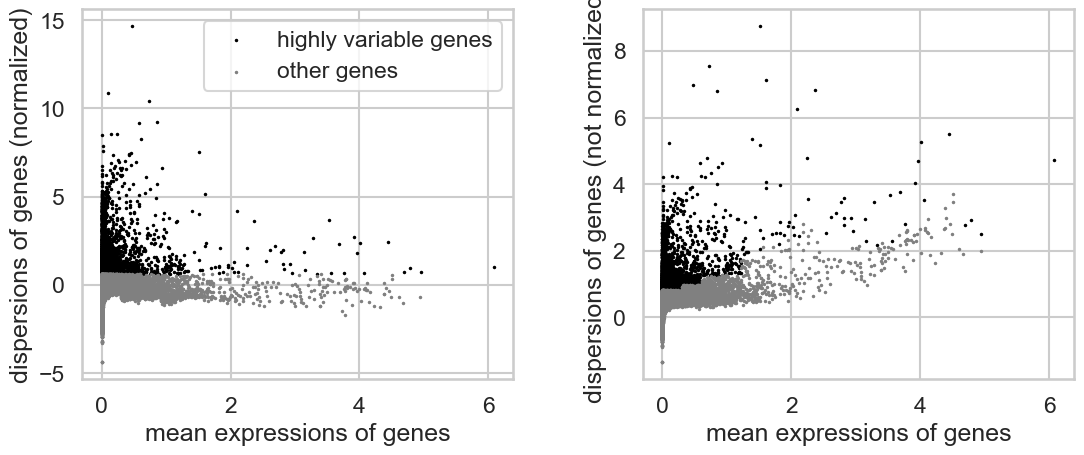

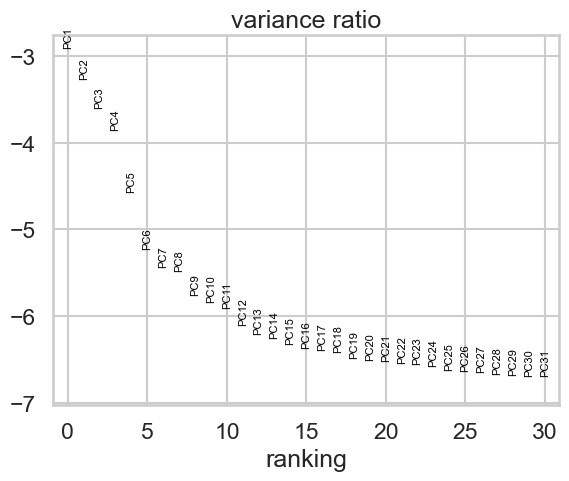

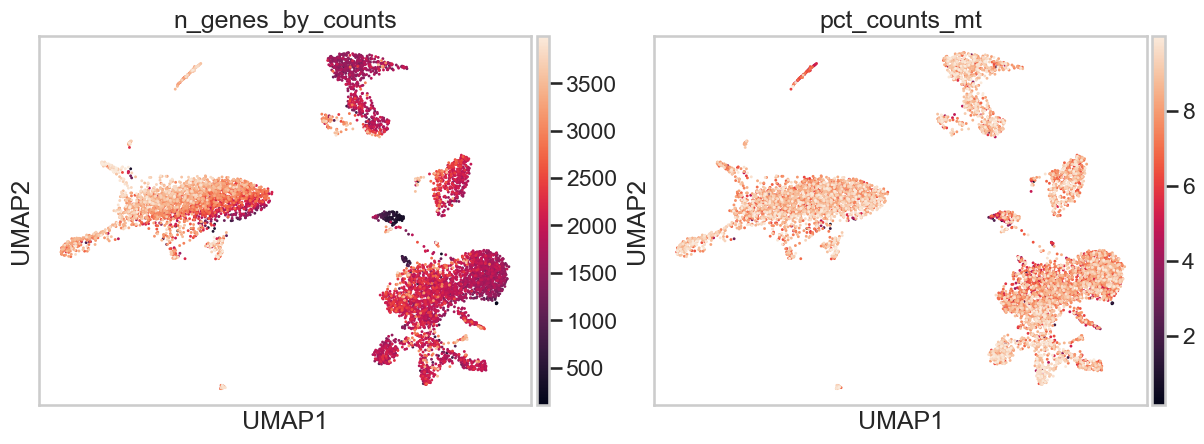

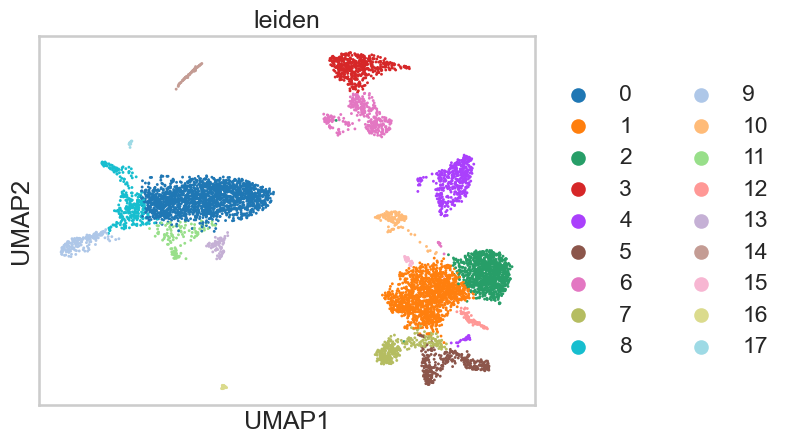

In [11]:
import scanpy as sc
import warnings
warnings.filterwarnings("ignore")

adata = sc.read_10x_h5("pbmc_10k_v3_filtered_feature_bc_matrix.h5")
print("Initial shape:", adata.shape)

adata.raw = adata


adata.var['mt'] = adata.var_names.str.startswith('MT-')  # Identify mitochondrial genes
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, inplace=True)  # Calculate metrics including mt percentage


adata = adata[adata.obs['n_genes_by_counts'] < 4000, :]
adata = adata[adata.obs['pct_counts_mt'] < 10, :]  # Now this will work because pct_counts_mt exists
print("After QC:", adata.shape)


sc.pp.normalize_total(adata, target_sum=1e4)


sc.pp.log1p(adata)


sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat')
print("Number of HVGs:", adata.var['highly_variable'].sum())


sc.pl.highly_variable_genes(adata, show=False)


adata = adata[:, adata.var['highly_variable']].copy()


sc.pp.scale(adata, max_value=10)


sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, show=False)


sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


sc.tl.umap(adata)
sc.pl.umap(adata, color=['n_genes_by_counts', 'pct_counts_mt'], show=False)


sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=['leiden'], show=False)


sc.tl.rank_genes_groups(adata, 'leiden', method='t-test', n_genes=25, key_added='rank_genes')
markers = sc.get.rank_genes_groups_df(adata, group=None, key='rank_genes')
markers.to_csv('pbmc10k_markers.csv', index=False)

print(" Marker genes saved: pbmc10k_markers.csv")

# Load 10x HDF5 filtered matrix

In [3]:


import os
import warnings
import numpy as np
import pandas as pd
import scanpy as sc


warnings.filterwarnings("ignore", message=".*Variable names are not unique.*")


h5_path = 'pbmc_10k_v3_filtered_feature_bc_matrix.h5'
adata = sc.read_10x_h5(h5_path)


adata.var_names_make_unique()


print('Data loaded successfully')
print('Shape of AnnData:', adata.shape)
print('Number of cells:', adata.n_obs)
print('Number of genes:', adata.n_vars)



Data loaded successfully
Shape of AnnData: (11769, 33538)
Number of cells: 11769
Number of genes: 33538


# Basic QC

In [4]:

adata.obs['n_counts'] = adata.X.sum(axis=1).A1 if hasattr(adata.X, 'A1') else np.array(adata.X.sum(axis=1)).ravel()
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1).A1 if hasattr(adata.X, 'A1') else (adata.X > 0).sum(axis=1)
mt_genes = adata.var_names.str.upper().str.startswith('MT-')
adata.var['mt'] = mt_genes
adata.obs['percent_mt'] = (adata.X[:, mt_genes].sum(axis=1).A1 if hasattr(adata.X, 'A1') else np.array(adata.X[:, mt_genes].sum(axis=1)).ravel()) / adata.obs['n_counts'] * 100
adata.obs[['n_counts','n_genes','percent_mt']].describe().T


,count,mean,std,min,25%,50%,75%,max
n_counts,11769.0,7644.850098,4709.121094,501.000000,4883.000000,6521.000000,9598.000000,79534.000000
n_genes,11769.0,2109.421616,940.065220,54.000000,1567.000000,1906.000000,2710.000000,7211.000000
percent_mt,11769.0,11.994768,12.726955,0.137714,7.703531,9.145336,11.099971,96.803375


# QC plots (violin and scatter)

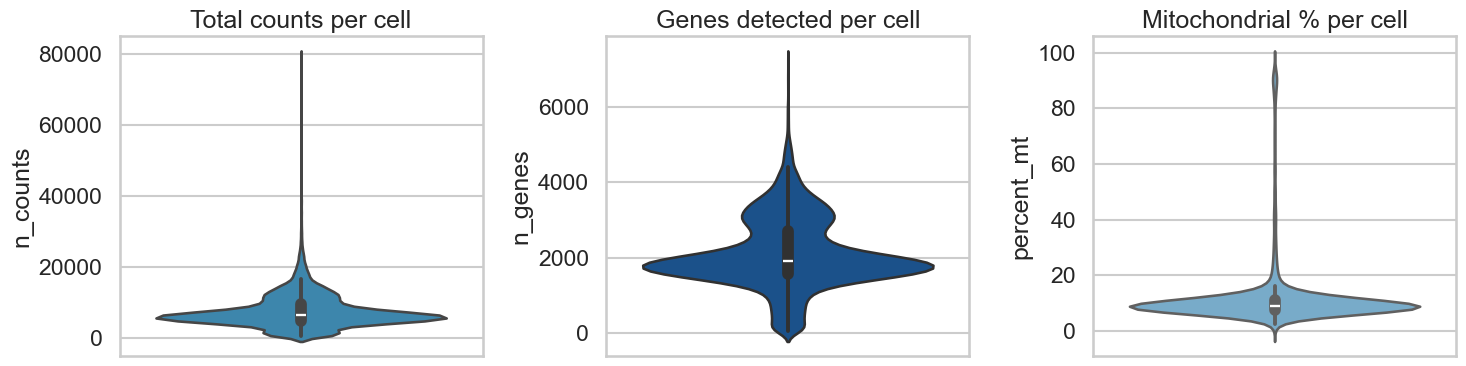

In [5]:

import matplotlib.pyplot as plt, seaborn as sns
sns.set(style='whitegrid', context='talk')
fig, axes = plt.subplots(1,3, figsize=(15,4))
sns.violinplot(y=adata.obs['n_counts'], ax=axes[0], color='#2b8cbe')
axes[0].set_title('Total counts per cell')
sns.violinplot(y=adata.obs['n_genes'], ax=axes[1], color='#08519c')
axes[1].set_title('Genes detected per cell')
sns.violinplot(y=adata.obs['percent_mt'], ax=axes[2], color='#6baed6')
axes[2].set_title('Mitochondrial % per cell')
plt.tight_layout()
plt.show()


# Filtering thresholds

In [6]:

min_genes = 200
max_mt = 10 
min_counts = 1000

sc.pp.filter_cells(adata, min_genes=min_genes)
adata = adata[adata.obs['percent_mt'] < max_mt, :]
adata = adata[adata.obs['n_counts'] > min_counts, :]
print('After filtering:', adata.shape)


After filtering: (7367, 33538)


# Selecting Highly Variable Genes

 Number of HVGs: 3000


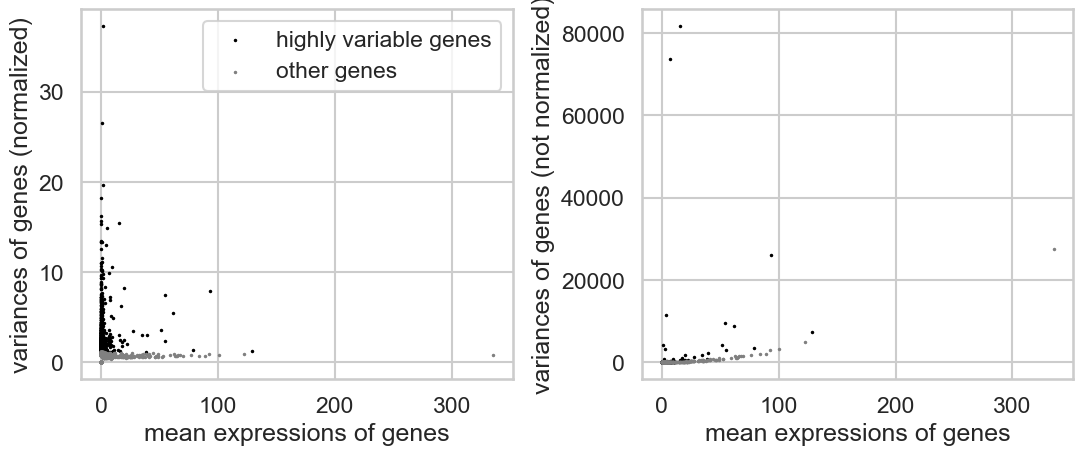

In [7]:


sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3')

print(' Number of HVGs:', adata.var['highly_variable'].sum())

sc.pl.highly_variable_genes(adata)


sc.pp.normalize_total(adata, target_sum=1e4)

sc.pp.log1p(adata)

# PCA, neighbours, UMAP, clustering

 PCA, UMAP, and Leiden clustering done!


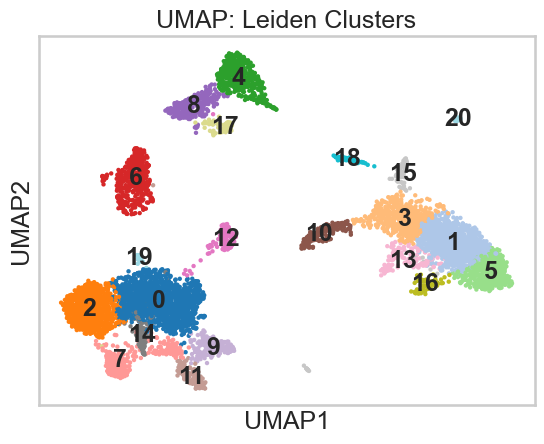

In [12]:

import numpy as np

if not isinstance(adata.X, np.ndarray):
    adata.X = adata.X.toarray() 

sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=15)
sc.tl.umap(adata, min_dist=0.5)
sc.tl.leiden(adata, resolution=0.8)

print(' PCA, UMAP, and Leiden clustering done!')
sc.pl.umap(
    adata,
    color='leiden',
    palette='tab20',
    size=40,
    legend_loc='on data',
    title='UMAP: Leiden Clusters'
)


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)



adata = adata[:, adata.var['highly_variable']]


adata = adata[:, adata.var['highly_variable']].copy()

sc.tl.rank_genes_groups(
    adata,
    groupby='leiden',
    method='wilcoxon',
    n_genes=25,
    key_added='rank_genes_wilcoxon',
    use_raw=False,
    pts=True,
    verbose=True
)


markers = sc.get.rank_genes_groups_df(adata, group=None, key='rank_genes_wilcoxon')
markers.to_csv('pbmc10k_markers.csv', index=False)




# Save processed AnnData

In [10]:

adata.write('pbmc10k_processed.h5ad')
print('Saved pbmc10k_processed.h5ad')

Saved pbmc10k_processed.h5ad
